In [11]:
'''
This script decodes the generated latent embedding into the gene expression matrix and draw the UMAP for the generated cells and real cells
''' 

'\nThis script decodes the generated latent embedding into the gene expression matrix and draw the UMAP for the generated cells and real cells\n'

In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

load AE. Change the path of autoencoder to your local path

In [13]:
# modify the num_genes if use your own dataset
def load_VAE():
    autoencoder = VAE(
        num_genes=17789,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('../data/pbmc_AE/model_seed=0_step=199999.pt'))
    return autoencoder

load real data for comparision

In [14]:
adata = sc.read_10x_mtx('../data/pbmc68k/data/pbmc68k/filtered_matrices_mex/hg19/')  # change this path to your local path
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)
gene_names = adata.var_names

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
cell_data = adata.X.toarray()[::5]
celltype = pd.read_csv('../data/pbmc68k/data/pbmc68k/filtered_matrices_mex/68k_pbmc_barcodes_annotation.tsv', sep='\t')['celltype'].values
adata.obs['celltype'] = celltype

load and decode conditional generated data

In [15]:
# if not generated all type of cells, use the real cell to balance the batchnorm in the scimilarity
adata_w = adata.copy()[::5]
adata_w.var_names = gene_names

autoencoder = load_VAE()
cell_w = autoencoder(torch.tensor(adata_w.X.toarray()).cuda(),return_latent=True).detach().cpu().numpy()

# concat this cell_w with cell_gen and send them to the autoencoder
# cell_gen_all = autoencoder(torch.tensor(np.concatenate((cell_gen,cell_w),axis=0)).cuda(),return_decoded=True).cpu().detach().numpy()
cell_w.shape

(13716, 128)

In [21]:
# take tabular muris dataset for example. modify this part if use your own dataset

cell_gen_all = []
gen_class = []

cato = ['CD14+ Monocyte', 'CD19+ B', 'CD34+', 'CD4+ T Helper2', 'CD4+/CD25 T Reg',
 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory', 'CD56+ NK',
 'CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic']
index2 = [0,1,2,3,4,5,6,7,8,9,10]

for i in index2:
    npzfile=np.load(f'../samples/pbmc/label/l1/pbmc{i}.npz',allow_pickle=True)
    length = min(adata[adata.obs['celltype']==cato[i]].X.shape[0],npzfile['samples'].shape[0])
    print("class num:",adata[adata.obs['celltype']==cato[i]].X.shape[0])
    cell_gen_all.append(npzfile['samples'][:int(length)])#.squeeze(1)

    gen_class+=['gen '+cato[i]]*int(length)
    print(f"{i}",np.array(gen_class).shape)
    
cell_gen_all = np.concatenate(cell_gen_all,axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

cell_gen = cell_gen_all
print(np.array(gen_class).shape,cell_gen.shape)
celltype.shape


class num: 571
0 (571,)
class num: 1232
1 (1595,)
class num: 52
2 (1647,)
class num: 23
3 (1670,)
class num: 1208
4 (2694,)
class num: 367
5 (3061,)
class num: 581
6 (3642,)
class num: 1733
7 (4666,)
class num: 4116
8 (5690,)
class num: 3402
9 (6714,)
class num: 431
10 (7145,)
(7145,) (7145, 17789)


(68579,)

plot UMAP

In [22]:
adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

# if conditional generate. other wise commented this.
adata.obs['celltype'] = np.concatenate((celltype[::5], gen_class))

adata.obs['cell_name'] = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

d:\pythonProject\anaconda\lib\site-packages\anndata\_core\anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [23]:
# the data is already log norm
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

d:\pythonProject\anaconda\lib\site-packages\scanpy\preprocessing\_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


draw plot of all cells if unconditional generation

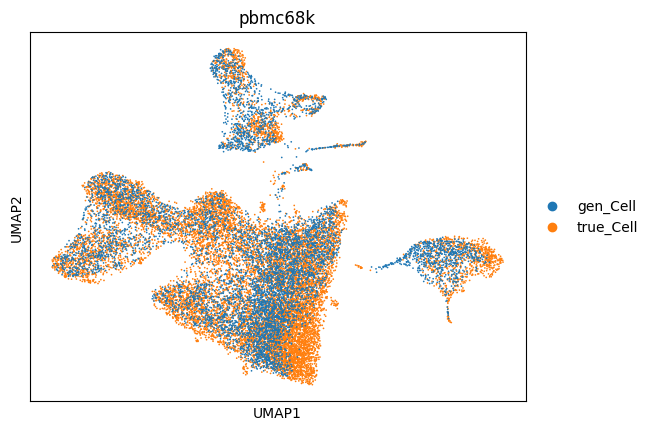

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata=adata,color="cell_name",size=6,title='pbmc68k')

draw plot of each cell type if conditional generation

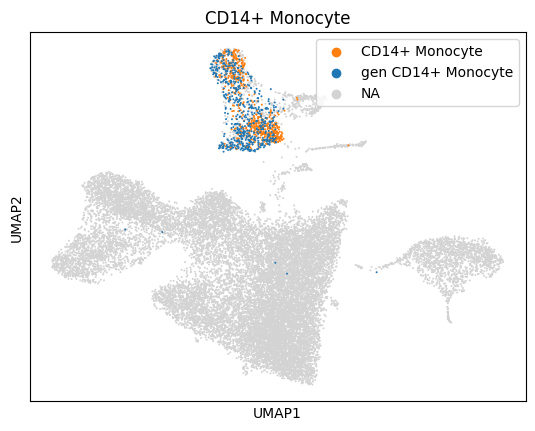

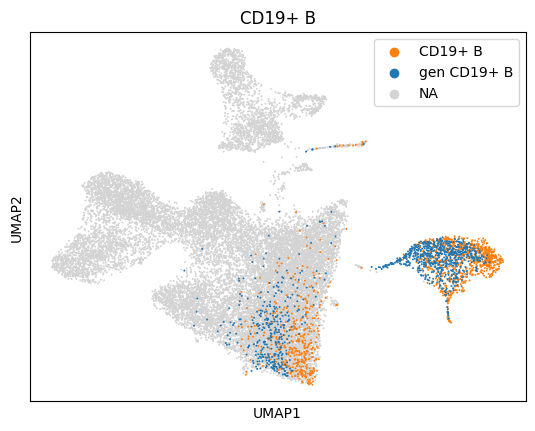

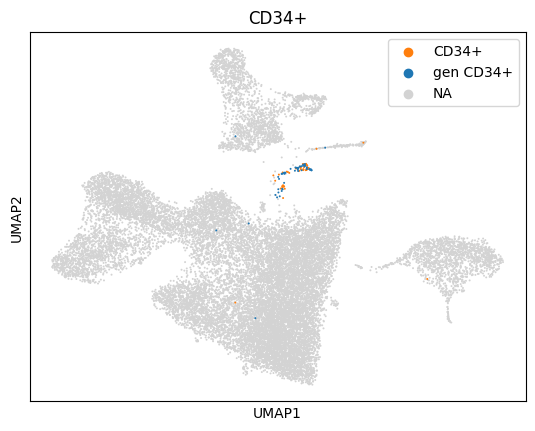

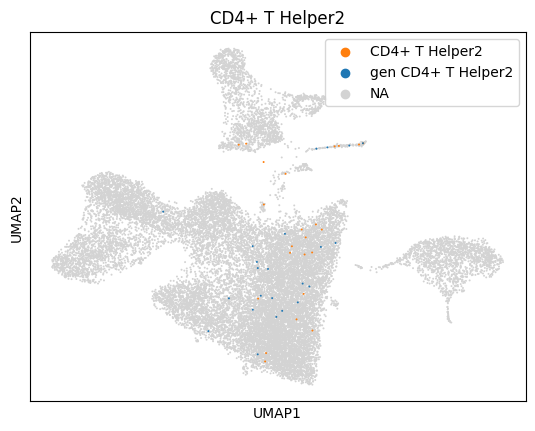

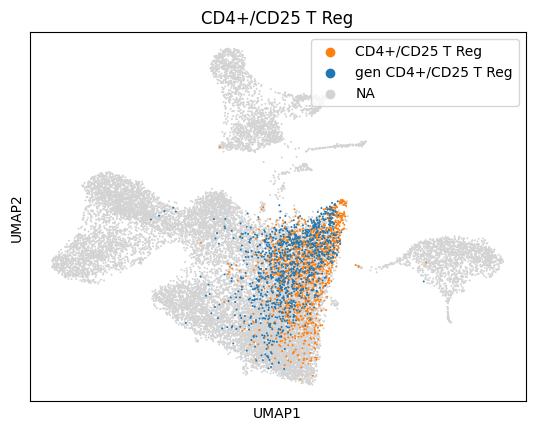

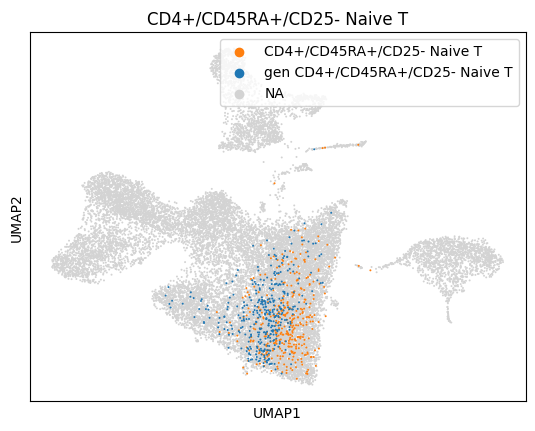

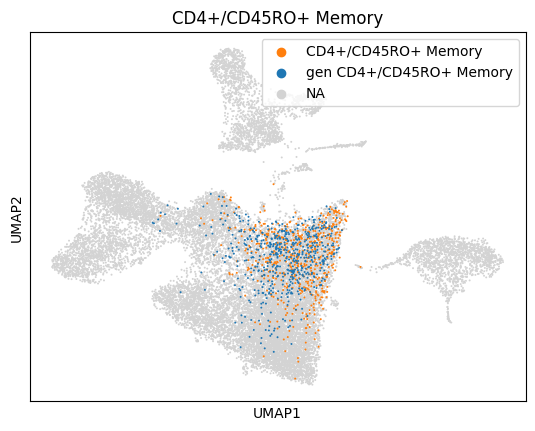

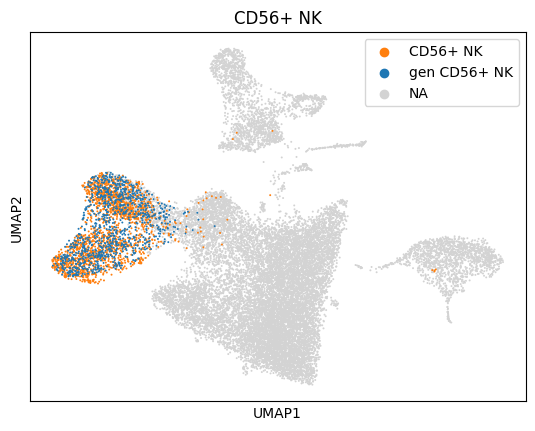

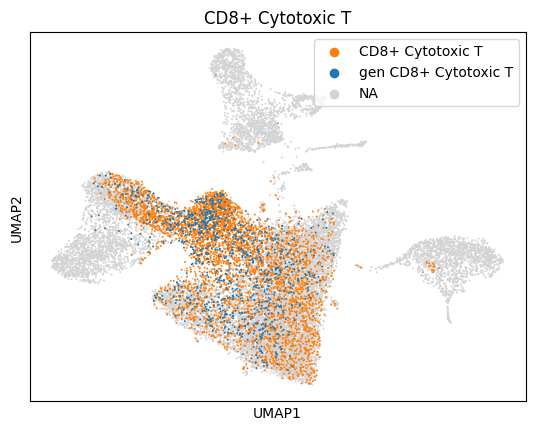

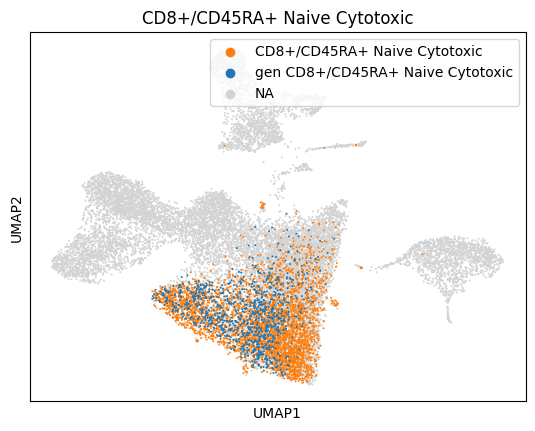

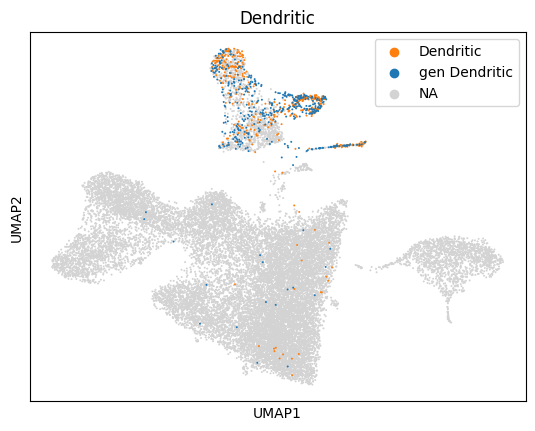

In [25]:
for categoray in cato:
    color_dict = {}
    for cat in adata.obs['celltype'].cat.categories:
        if cat == categoray:
            color_dict[cat] = 'tab:orange'
        elif cat == 'gen '+categoray:
            color_dict[cat] = 'tab:blue'
        else:
            color_dict[cat] = 'black'
    sc.pl.umap(adata=adata,color="celltype",groups=[categoray,'gen '+categoray], size=8, palette=color_dict, show = False)
    plt.legend(loc = 'upper right')
    plt.title(categoray)
